# **Synthetic case: A convex setting**
$$f_t(x) =  \begin{cases} 
      1010x & \text{for } t \text{ mod 101} = 1\\
      -10x & \text{otherwise}
   \end{cases} $$

With $\mathcal{F}$ = [−1; 1]. \\
The optimal solution is x = −1, providing the minimum regret. Thus, for convergence, we expect the algorithms to converge to x = −1. 

However, as we see in the paper, the ADAM method fails to converge to −1 and instead converges to the suboptimal solution of x = 1. This behavior is due to the exponential moving averages of squared past gradients that causes the rare but informative gradients to die out quickly. The gradient that is useful for optimal convergence will rarely appear (with probability of 0.01) and hence the ADAM method will not be able to effectively use
this information. AMSGRAD does not suffer from the same problem, hence
reaching the optimal solution.

**Algorithm 1: ADAM**

![alt text](https://i.imgur.com/vQpTtcE.png)
![alt text](https://i.imgur.com/mmi1Fse.png)

(According to proof of theorem 1 on the paper) Without loss of generality, assume that the initial point is $x_1$. This can
be assumed without any loss of generality because for any choice of initial point, we can always
translate the coordinate system such that the initial point is $x_1 $ in the new coordinate system
and then choose the sequence of functions as above in the new coordinate system. Hence, we set $\epsilon = 0$.

Hyper-parameter: $\beta_1 = 0.9, \beta_2 = 0.99, \alpha = 0.001 $

In [0]:
%tensorflow_version 1.x 
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
class AdamOptimizer(tf.train.Optimizer):
  def __init__(self, learning_rate=0.001, decay=False, beta1=0.9, beta2=0.99,
               epsilon=0.0, var_list=[]):
    self.learning_rate = learning_rate
    self.decay = decay
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    
    self.var_list = var_list
    self.m = {}
    self.v = {}
    self.beta1_t = tf.Variable(1.0, trainable=False)
    self.beta2_t = tf.Variable(1.0, trainable=False)
    self.t = tf.Variable(0.0, trainable=False)
    
    for var in self.var_list:
      self.m[var] = tf.Variable(tf.zeros(tf.shape(var.initial_value)), trainable=False)
      self.v[var] = tf.Variable(tf.zeros(tf.shape(var.initial_value)), trainable=False)
    
  def apply_gradients(self, gradient_variables):
    beta1_t = self.beta1_t.assign(self.beta1_t * self.beta1)
    beta2_t = self.beta2_t.assign(self.beta2_t * self.beta2)
    
    with tf.control_dependencies([self.t.assign_add(1.0), beta1_t, beta2_t]):
      learning_rate = self.learning_rate
      # if self.decay:
      #   learning_rate /= tf.sqrt(self.t)
      update_ops = []

      for (g, var) in gradient_variables:
        m = self.m[var].assign(self.beta1 * self.m[var] + (1 - self.beta1) * g)
        v = self.v[var].assign(self.beta2 * self.v[var] + (1 - self.beta2) * g * g)
        m_hat = m / (1 - beta1_t)
        v_hat = v / (1 - beta2_t)

        update = -learning_rate * m_hat / (self.epsilon + tf.sqrt(v_hat))
        update_ops.append(var.assign_add(update))

      return tf.group(*update_ops)

In [0]:
class AMSGradOptimizer(tf.train.Optimizer):
  def __init__(self, learning_rate=0.001, decay=False, beta1=0.9, beta2=0.99,
               epsilon=0.0, var_list=[]):
    self.learning_rate = learning_rate
    self.decay = decay
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    
    self.var_list = var_list
    self.m = {}
    self.v = {}
    self.v_hat = {}
    self.t = tf.Variable(0.0, trainable=False)
    
    for var in self.var_list:
      self.m[var] = tf.Variable(tf.zeros(tf.shape(var.initial_value)), trainable=False)
      self.v[var] = tf.Variable(tf.zeros(tf.shape(var.initial_value)), trainable=False)
      self.v_hat[var] = tf.Variable(tf.zeros(tf.shape(var.initial_value)), trainable=False)
    
  def apply_gradients(self, gradient_variables):
    with tf.control_dependencies([self.t.assign_add(1.0)]):
      learning_rate = self.learning_rate
      # if self.decay:
      #   learning_rate /= tf.sqrt(self.t)
      update_ops = []

      for (g, var) in gradient_variables:
        m = self.m[var].assign(self.beta1 * self.m[var] + (1 - self.beta1) * g)
        v = self.v[var].assign(self.beta2 * self.v[var] + (1 - self.beta2) * g * g)
        v_hat = self.v_hat[var].assign(tf.maximum(self.v_hat[var], v))

        update = -learning_rate * m / (self.epsilon + tf.sqrt(v_hat))
        update_ops.append(var.assign_add(update))

      return tf.group(*update_ops)

In [0]:
def test_optimizer(optimizer_name, iterations=1000000, learning_rate=0.001,
                   decay=False):
  tf.reset_default_graph()
  
  with tf.Session() as sess:
    r = tf.distributions.Bernoulli(probs=0.01, dtype=tf.float32).sample()
    x = tf.Variable(0.0)
    loss = (r * 1010 - (1 - r) * 10) * x
    var_list = [x]
    gradient = tf.gradients(loss, var_list)

    if optimizer_name == "adam":
      optimizer = AdamOptimizer(var_list=var_list, learning_rate=learning_rate,
                                decay=decay)
    elif optimizer_name == "amsgrad":
      optimizer = AMSGradOptimizer(var_list=var_list, learning_rate=learning_rate,
                                   decay=decay)
    else:
      raise Exception("Unknown optimizer")

    update_op = optimizer.apply_gradients([(grad, var) for grad, var in zip(gradient, var_list)])
    with tf.control_dependencies([update_op]):
      clip_op = x.assign(tf.clip_by_value(x, -1.0, 1.0))

    sess.run(tf.global_variables_initializer())

    results = []

    for i in range(iterations):
      _, cur_x = sess.run([clip_op, x])
      results.append(cur_x)
      
      if i % 50000 == 0:
        print(cur_x)

    return results

In [0]:
results_adam = test_optimizer("adam", iterations=1000000, learning_rate=0.001)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
0.0
1.0
0.96079737
0.9893045
0.99347013
0.9678837
0.97701055
0.9902505
1.0
1.0
1.0
0.99248874
0.987633
0.9878476
0.97927845
0.9834641
0.95851386
0.98906547
0.9775075
1.0


In [0]:
results_amsgrad = test_optimizer("amsgrad", iterations=2000000, learning_rate=0.001)

0.0
0.28722277
0.17926161
-0.037190784
-0.1398136
-0.1732991
-0.37207317
-0.49669042
-0.5502147
-0.5162109
-0.52157235
-0.28044268
-0.4484797
-0.5126171
-0.5635477
-0.5927723
-0.63691163
-0.7030826
-0.7539578
-0.64871293
-0.90225124
-0.7936022
-0.7143659
-0.76951736
-0.87768614
-0.8017726
-0.91157967
-0.8601429
-0.9747956
-0.9957222
-0.96554255
-0.87812936
-0.9693847
-0.9876074
-0.96591234
-0.9350075
-0.99352664
-0.99467266
-0.97512734
-0.9367569


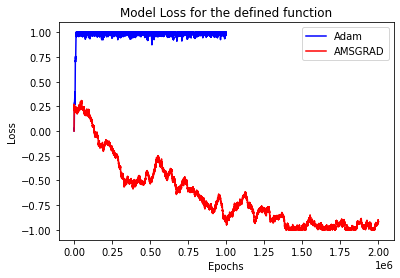

In [0]:
plt.plot(results_adam, label="Adam", color=(0,0,1))
plt.plot(results_amsgrad, label="AMSGRAD",color=(1,0,0))
plt.legend(bbox_to_anchor=(0.8, 0.9), loc=2, borderaxespad=0.)


plt.title('Model Loss for the defined function')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()